Document summarization using Pointer Generator Network 

paper - https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/custom/15784595.pdf
![pointer generator network](pointer_generator.png)"

Dataset - CNN/DM dataset of 300,000 pairs of news articles and corresponding multi-sentence summaries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
import torch.nn as nn
import math
from torch import optim
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from collections import Counter
from random import shuffle
import numpy as np
import gzip
from torch.utils.data import Dataset, DataLoader
import pickle
from torch.nn.utils.rnn import pack_sequence
from torch.nn import functional as F

In [0]:
class Params:
  hidden_size = 512  
  embedding_size = 300
  shuffle=True
  learning_rate=.001
  num_epochs=500
  data_path = '/content/drive/My Drive/cnndm.gz'
  val_data_path = '/content/drive/My Drive/cnndm.val.gz'
  eps=1e-31
  batch_size=2
  model_path='/content/drive/My Drive/model.pt'
  losses_path='/content/drive/My Drive/val_losses.pkl'
  embedding_file='/content/drive/My Drive/glove.6B.300d.txt'
  # Testing
  test_data_path: str = '/content/drive/My Drive/cnndm.test.gz'
  vocab_file = '/content/drive/My Drive/vocab.pkl'
  src_length = 400
  tgt_length = 128

In [0]:
# when vocab is created using words from training data
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence:
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [0]:
def simple_tokenizer(text, lower=False, newline=None):
  if lower:
    text = text.lower()
  if newline is not None:  # replace newline by a token
    text = text.replace('\n', ' ' + newline + ' ')
  return text.split()

In [0]:
class Vocab(object):
  PAD = 0
  SOS = 1
  EOS = 2
  UNK = 3
  def __init__(self):
    self.word2index = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}
    self.word2count = Counter()
    self.reserved = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
    self.index2word = self.reserved[:]
    self.embeddings=[[0 for i in range(300)],[0 for i in range(300)],[0 for i in range(300)],[0 for i in range(300)]]

  def add_words(self, words):
    for word in words:
      if word not in self.word2index:
        self.word2index[word] = len(self.index2word)
        self.index2word.append(word)
    self.word2count.update(words)

  def add_embedding(self,embedding):
    self.embeddings.append(embedding) 

  def __getitem__(self, item):
    if type(item) is int:
      return self.index2word[item]
    return self.word2index.get(item, self.UNK)

  def __len__(self):
    return len(self.index2word)    

In [0]:
class Dataset(nn.Module):
  def __init__(self, filename, src_len,tgt_len,tokenize=simple_tokenizer,max_size=None):
    print("Reading dataset %s..." % filename, end=' ', flush=True)
    self.filename = filename
    self.pairs = []
    self.src_len = 0
    self.tgt_len = 0
    if filename.endswith('.gz'):
      open = gzip.open
    with open(filename, 'rt', encoding='utf-8') as f:
      for i, line in enumerate(f):
        pair = line.strip().split('\t')
        if len(pair) != 2:
          continue
        src = tokenize(pair[0])
        if(len(src)>src_len):
           src=src[:src_len]
        tgt = tokenize(pair[1])
        if(len(tgt)>tgt_len):
           tgt=tgt[:tgt_len]        
        self.pairs.append((src, tgt))
        if(max_size and len(self.pairs)==max_size):
          break
    print("%d pairs." % len(self.pairs))

  def build_vocab(self, embedding_file=None):
    # word frequency
    word_counts={}
    count_words(word_counts,[src+tgr for src,tgr in self.pairs])
    vocab=Vocab()
    if(embedding_file):
      with open(embedding_file, 'rt', encoding='utf-8') as f:
        for line in f:
          splitline=line.split()
          vocab.add_words([splitline[0]])
          vocab.add_embedding([float(value) for value in splitline[1:]])
    else:  
      for word,count in word_counts.items():
          if(count>20):
              vocab.add_words([word])  
    self.vocab=vocab 
  def vectorize(self,tokens):
    return [self.vocab[token] for token in tokens]
  def unvectorize(self, indices):
    return [self.vocab[i] for i in indices]
  def __getitem__(self, index):
    return {'x':self.vectorize(self.pairs[index][0]),
            'y':self.vectorize(self.pairs[index][1]),
            'src':self.pairs[index][0],
            'trg':self.pairs[index][1],
            'x_len':len(self.pairs[index][0]),
            'y_len':len(self.pairs[index][1])}
  def __len__(self):
    return len(self.pairs)    

Positional Embedding
*   Sin and cos functions represent binary alternating sequence
*   Both Sin and cos are used as it allows for linear transformation, and hence relative position, which varies linearly with time
*   As mentioned in "attention is all you need" paper, learn embeddings are almost identical to sinusoidal embeddings, i decide to go with fixed sinusoidal embeddings

query
*   Why not just use One-hot embedding instead of sin,cos functions (to be experimented)
*   Learnt embedding is made larger by multiplying with square root of embedding dimension (as mentioned in paper); i suppose word meaning is more important than it's position in sequence and this larger number makes training faster. To be removed and experimented. Also, why not just use a constant to multiply?

In [0]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 400):
        super(PositionalEncoder,self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model,requires_grad=False,dtype=torch.float).to(device)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        self.register_buffer('pe',pe.unsqueeze(0))
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(float(self.d_model))
        #add positional embedding
        seq_len = x.size(1)
        # pe = torch.tensor(self.pe[:,:seq_len],requires_grad=False).to(device)
        pe = self.pe[:,:seq_len,:].clone().detach()
        return x + pe.expand_as(x)

*   From the paper - 'We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients.To counteract this effect, we scale the dot products'
Softmax function:
![softmax](Softmax_Graph.png)"
![softmax](softmax_reduced.png)"

If the magnitudes grow large, the softmax function is such that it magnifies such values and suppress lower values, in terms of probabilities.
On the other hand, if we reduce the magnitude, we get a gradual slope and for most inputs, we have bigger gradients.

*   Masking is used for decoder self attention, because decoding is done sequentially and during training we consider the whole sequence as it makes training faster. To factor time step, I assign 0 to leaked attentions.
Suppose decoded sequence is 5 tokens long. Scores last 2 dimensions will be 5x5.Here rows represent time steps, hence we need to make non-highlighted cells 0. 

![masking](masking.png)"




In [0]:
def attention(q, k, v, d_k,mask=False,cover=None):
  scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
  scores = F.softmax(scores, dim=-1) 
  if mask:
    tensor_mask=torch.ones(scores.shape).to(device)
    for row in range(tensor_mask.size(-2)):
      for col in range(tensor_mask.size(-1)):
        if(row>col):
          tensor_mask[:,:,row,col]=0 
    scores=scores * tensor_mask       
    scores=scores.transpose(-2,-1)   
  if(not cover is None):
    tensor_mask=torch.ones(scores.size(0),scores.size(1),scores.size(-1),scores.size(-1)).to(device)
    for row in range(tensor_mask.size(-2)):
      for col in range(tensor_mask.size(-1)):
        if(row>=col):
          tensor_mask[:,:,row,col]=0 
    tensor_mask=tensor_mask.transpose(-2,-1) 
    cv=torch.matmul(scores,tensor_mask)
    cover+=torch.sum(torch.min(cv,scores),[0,1,2,3])     
    # print(cover)     
  output = torch.matmul(scores, v)
  return output

*   From the paper - "Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this." - Not clear, to be experimented.
*   In case of self attention, q,k,v are encoder or decoder embeddings. Perhaps, we want to learn 2 representations for each token - q and k (similar to word2vec where we have 2 vectors for each word, one when it is part of context and when it is central word?). This would explain multiple heads and then linear transformation(to be verified).

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self,hidden_size,heads=8):
        super(MultiHeadAttention, self).__init__()
        self.heads=heads 
        self.d_k = hidden_size // heads
        self.hidden_size=hidden_size
        self.q_linear = nn.Linear(hidden_size, hidden_size,bias=False)
        self.v_linear = nn.Linear(hidden_size, hidden_size,bias=False)
        self.k_linear = nn.Linear(hidden_size, hidden_size,bias=False)        
    
    def forward(self, q, k, v,mask=False,cover=None):        
        bs = q.size(0)
        k = self.k_linear(k).view(bs,-1,self.heads,self.d_k)
        q = self.q_linear(q).view(bs,-1,self.heads,self.d_k)
        v = self.v_linear(v).view(bs,-1,self.heads,self.d_k)

        k=k.transpose(1,2)
        q=q.transpose(1,2)
        v=v.transpose(1,2)

        scores = attention(q, k, v, self.d_k,mask,cover)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.hidden_size)
        return concat
        # return scores.view(bs, -1, self.hidden_size)

*   Skip connection to maintain position information (Only 1 transformer layer used as of now, to be experimented with more layers)
*   From pytorch documentation - "γ and β are learnable affine transform parameters of normalized_shape if elementwise_affine is True."-- To be explored

In [0]:
class Norm(nn.Module):
  def __init__(self,hidden_size):
    super(Norm, self).__init__()
    self.norm=nn.LayerNorm(hidden_size,elementwise_affine=False)
  def forward(self,x,res):
    x=x+self.norm(res)
    return x

In [0]:
class FeedForward(nn.Module):
  def __init__(self,hidden_size,d_ff=2048):
    super(FeedForward, self).__init__()
    self.linear_1=nn.Linear(hidden_size,d_ff)
    self.linear_2=nn.Linear(d_ff,hidden_size)
  def forward(self,x):
    output=self.linear_1(x)
    output=self.linear_2(output)
    return output

In [0]:
class Encoder(nn.Module):
  def __init__(self,embedding_size,hidden_size,vocab_size,embedding_weights):
    super(Encoder, self).__init__()
    self.hidden_size=hidden_size
    self.pos=PositionalEncoder(embedding_size)
    self.embedding=nn.Embedding(vocab_size,embedding_size,padding_idx=0,_weight=embedding_weights)
    self.embedding.weight.requires_grad=False
    self.linear=nn.Linear(embedding_size,hidden_size)
    self.attn=MultiHeadAttention(hidden_size)
    self.norm=Norm(hidden_size)
    self.ff=FeedForward(hidden_size)
  def forward(self,seq):
    embedded=self.embedding(seq)
    embedded=self.pos(embedded)
    embedded=self.linear(embedded)
    output=self.attn(embedded,embedded,embedded)
    output=self.norm(embedded,output)
    res=self.ff(output)
    output=self.norm(output,res)
    return output

In [0]:
class Decoder(nn.Module):
  def __init__(self,embedding_size,hidden_size,vocab_size,embedding_weights):
    super(Decoder, self).__init__()
    self.hidden_size=hidden_size
    self.pos=PositionalEncoder(embedding_size)
    self.embedding=nn.Embedding(vocab_size,embedding_size,padding_idx=0,_weight=embedding_weights)
    self.embedding.weight.requires_grad=False
    self.linear=nn.Linear(embedding_size,hidden_size)
    self.attn_1=MultiHeadAttention(hidden_size)
    self.attn_2=MultiHeadAttention(hidden_size)
    self.norm=Norm(hidden_size)
    self.ff=FeedForward(hidden_size)
  def forward(self,seq,enc_output,coverage=None):
    embedded=self.embedding(seq)
    embedded=self.pos(embedded)
    embedded=self.linear(embedded)
    output=self.attn_1(embedded,embedded,embedded,True)
    output=self.norm(embedded,output)
    res=self.attn_2(output,enc_output,enc_output,cover=coverage)
    output=self.norm(output,res)
    res=self.ff(output)
    dec_output=self.norm(output,res)
    return output,dec_output,embedded

From decoder-
  1. output - normalized output from encoder attention 
  2. decoder output - final decoder output after feedforward and normalization
  3. embedding - input embedding to be used for p_gen calculation

* At each time step, generation probability is learnt:
* Attention distribution over encoder sequence , using output from above
* Encoder output is weighed by attention distribution calculated in step1
* Mean of Encoder output calculate in step is taken across sequence length
For each tensor in batch:
   * Mean encoder vector, calculated above is linearly transformed 
   For each decoder sequence step:   
     1. decoder output is linearly transformed from hidden_dim(512) to 1
     2. embedding is linearly transformed
     3. All 3 tensors are added and sigmoid is applied
* p_gen is accumulated for each tensor in batch and for each step in decoder sequence 
* pointer probability is 1-p_gen
* Generation probabilities are calculated by projecting final decoder output to fixed vocubulary
* Pointer probabilities are added to generation probabilities using dynamic vocubulary (created in each batch), at locations provided by the expanded encoder indexes multiplied by pointer probabilities
* log is taken of final probability, as we are working in log domain to avoid underflow     

In [0]:
class Transformer(nn.Module):
  def __init__(self,vocab,embedding_size,hidden_size,embedding_weights):
    super(Transformer, self).__init__()
    self.vocab=vocab
    self.vocab_size=len(vocab)
    self.hidden_size=hidden_size
    self.encoder=Encoder(embedding_size,hidden_size,self.vocab_size,embedding_weights)
    self.decoder=Decoder(embedding_size,hidden_size,self.vocab_size,embedding_weights)
    self.linear=nn.Linear(hidden_size,self.vocab_size)
    self.softmax=nn.Softmax(dim=-1)
    self.sigmoid=nn.Sigmoid()
    self.attn=MultiHeadAttention(hidden_size) 
    self.enc_linear=nn.Linear(hidden_size,1)
    self.dec_linear=nn.Linear(hidden_size,1)
    self.embd_linear=nn.Linear(hidden_size,1)

  def forward(self,x,y,extra_vocab,expanded_word_idx,coverage=None,test=False,file_name=''):
    enc_output=self.encoder(x)
    output,dec_output,embedded=self.decoder(y,enc_output,coverage)
    gen_output=self.softmax(self.linear(dec_output))
    # print(torch.argmax(gen_output[:,-1,:],dim=-1))
    ptr_output=self.attn(enc_output,output,output)
    ptr_mean=torch.mean(ptr_output,-2).squeeze(-1)
    pb_gen=[]

    for b in range(dec_output.size(0)):
      p_gen=[]
      for t in range(dec_output.size(-2)):
        p_gen.append(self.sigmoid(self.enc_linear(ptr_mean[b,:])+self.dec_linear(dec_output[b,t,:])+self.embd_linear(embedded[b,t,:])))
      pb_gen.append(p_gen)  
    pb_gen=torch.tensor(pb_gen).to(device)    
    gen_output=F.pad(gen_output,(0,len(extra_vocab)),'constant')
    ptr_dist=F.softmax(torch.matmul(output, enc_output.transpose(-2,-1)),dim=-1)  
    pb_ptr=(1-pb_gen).unsqueeze(-1).expand_as(ptr_dist)
    gen_output.scatter_add_(2,expanded_word_idx.unsqueeze(1).expand(-1,gen_output.size(1),-1),ptr_dist*pb_ptr)
    return torch.log(gen_output+1e-5)

In [0]:
class Transformer_Infer(nn.Module):
  def __init__(self,vocab,embedding_size,hidden_size,embedding_weights):
    super(Transformer_Infer, self).__init__()
    self.vocab=vocab
    self.vocab_size=len(vocab)
    self.hidden_size=hidden_size
    self.encoder=Encoder(embedding_size,hidden_size,self.vocab_size,embedding_weights)
    self.decoder=Decoder(embedding_size,hidden_size,self.vocab_size,embedding_weights)
    self.linear=nn.Linear(hidden_size,self.vocab_size)
    self.softmax=nn.Softmax(dim=-1)
    self.sigmoid=nn.Sigmoid()
    self.attn=MultiHeadAttention(hidden_size) 
    self.enc_linear=nn.Linear(hidden_size,1)
    self.dec_linear=nn.Linear(hidden_size,1)
    self.embd_linear=nn.Linear(hidden_size,1)

  def forward(self,x,y,extra_vocab,expanded_word_idx,coverage=None,test=False,file_name=''):
    enc_output=self.encoder(x)
    output,dec_output,embedded=self.decoder(y,enc_output,coverage)
    gen_output=self.softmax(self.linear(dec_output))
    # print(torch.argmax(gen_output[:,-1,:],dim=-1))
    ptr_output=self.attn(enc_output,output,output)
    ptr_mean=torch.mean(ptr_output,-2).squeeze(-1)
    pb_gen=[]

    for b in range(dec_output.size(0)):
      # p_gen=[]
      # for t in range(dec_output.size(-2)):
      # print(ptr_mean.shape,dec_output.shape,embedded.shape)
      pb_gen.append(self.sigmoid(self.enc_linear(ptr_mean[b,:])+self.dec_linear(dec_output[b,-1,:])+self.embd_linear(embedded[b,-1,:])))
      # pb_gen.append(p_gen)  
    pb_gen=torch.tensor(pb_gen).view(-1,1).to(device) 
    gen_output= gen_output[:,-1,:]  
    gen_output=F.pad(gen_output,(0,len(extra_vocab)),'constant')
    ptr_dist=F.softmax(torch.matmul(output, enc_output.transpose(-2,-1)),dim=-1)  
    pb_ptr=(1-pb_gen)#.unsqueeze(-1).expand_as(ptr_dist)
    # print(gen_output.shape,expanded_word_idx.shape,ptr_dist[:,-1,:].squeeze().shape,pb_ptr.shape)
    gen_output.scatter_add_(1,expanded_word_idx,ptr_dist[:,-1,:].squeeze()*pb_ptr)
    return torch.log(gen_output+1e-5)

A function is hooked into dataloader, as we dont set a max sequence length here.
Padding has to be done for each batch

In [0]:
def my_collate(batch):
    max_x=np.max([item['x_len'] for item in batch])
    max_y=np.max([item['y_len'] for item in batch])
    
    x = [F.pad(torch.tensor(item['x']), (0,max_x-len(item['x'])), 'constant').tolist() for item in batch]    
    y = [F.pad(torch.tensor(item['y']), (0,max_y-len(item['y'])), 'constant').tolist() for item in batch]
    
    src=[item['src'] for item in batch]
    trg=[item['trg'] for item in batch]
    return {'x':x,'y': y,'src':src,'trg':trg,'x_len':[item['x_len'] for item in batch],'y_len':[item['y_len'] for item in batch]}

In [0]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''
    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''
        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [37]:
with torch.autograd.set_detect_anomaly(True):
  p=Params()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  batch_size=p.batch_size
  dataset=Dataset(p.data_path,p.src_length,p.tgt_length,max_size=100)
  dataset.build_vocab(p.embedding_file)
  embedding_weights=torch.tensor(dataset.vocab.embeddings).to(device)
  valset=Dataset(p.val_data_path,p.src_length,p.tgt_length,max_size=10)
  valset.vocab=dataset.vocab
  dataloader = DataLoader(dataset,p.batch_size,p.shuffle,collate_fn=my_collate)
  valloader = DataLoader(valset,p.batch_size,p.shuffle,collate_fn=my_collate)
  model=Transformer(dataset.vocab,p.embedding_size,p.hidden_size,embedding_weights).to(device)
  # model.load_state_dict(torch.load(p.model_path))
  # optimizer = optim.Adam(model.parameters(), lr=p.learning_rate)
  optimizer = ScheduledOptim(
        optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),2.0, 512, 4000)
  # criterion = nn.NLLLoss(ignore_index=dataset.vocab.PAD)

  training_loss=[]
  validation_loss=[]
  # training and vaildation losses are sum of corresponding batch losses and are added in above lists
  for _e in range(p.num_epochs):
    epoch_tr_loss=0
    epoch_vl_loss=0
    for batch in tqdm(dataloader):
      # print(torch.cuda.memory_allocated(device="cuda"))
      optimizer.zero_grad()
      extra_vocab={}
      expanded_x=[]
      expanded_y=[]
      
      x=torch.tensor(batch['x']).to(device)
      y=torch.tensor(batch['y']).to(device)
      src=batch['src']
      trg=batch['trg']

      max_src=np.max(batch['x_len'])
      for sent in src:
        vec=[]
        for token in sent:
          if(token in extra_vocab.keys()):
            vec.append(extra_vocab[token]) 
          elif(token not in dataset.vocab.word2index):
            extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
            vec.append(extra_vocab[token])
          else:
            vec.append(dataset.vocab[token])  
        expanded_x.append(vec + [0 for i in range(max_src-len(vec))])
      expanded_x=torch.tensor(expanded_x).to(device)  

      max_trg=np.max(batch['y_len'])
      for sent in trg:
        vec=[]
        for token in sent:
          if(token in extra_vocab.keys()):
            vec.append(extra_vocab[token]) 
          elif(token not in dataset.vocab.word2index):
            extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
            vec.append(extra_vocab[token])
          else:
            vec.append(dataset.vocab[token])             
        expanded_y.append(vec + [0 for i in range(max_trg-len(vec))])          
      expanded_y = torch.tensor(expanded_y).to(device)
      '''
        y is used as input, expanded y for validation and expanded x for pointer probability
      '''
      coverage=torch.tensor(0,dtype=torch.float).to(device)
      y=torch.cat((torch.tensor([dataset.vocab.SOS] * y.size(0), device=device).view(-1,1),y[:,:-1]),dim=1)
      pred=model(x,y,extra_vocab,expanded_x,coverage)
      loss=F.nll_loss(pred.permute(0,2,1), expanded_y, ignore_index=dataset.vocab.PAD, reduction='sum')
      print(loss,coverage)
      loss=loss+coverage
      loss.backward()
      optimizer.step_and_update_lr() 
      epoch_tr_loss+=loss.data.item()
    training_loss.append(epoch_tr_loss)
    with torch.no_grad():
      for batch in tqdm(valloader):
        # optimizer.zero_grad()
        extra_vocab={}
        expanded_x=[]
        expanded_y=[]
        
        x=torch.tensor(batch['x']).to(device)
        y=torch.tensor(batch['y']).to(device)
        src=batch['src']
        trg=batch['trg']

        max_src=np.max(batch['x_len'])
        for sent in src:
          vec=[]
          for token in sent:
            if(token in extra_vocab.keys()):
              vec.append(extra_vocab[token]) 
            elif(token not in dataset.vocab.word2index):
              extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
              vec.append(extra_vocab[token])
            else:
              vec.append(dataset.vocab[token])               
          expanded_x.append(vec + [0 for i in range(max_src-len(vec))])
        expanded_x=torch.tensor(expanded_x).to(device)  

        max_trg=np.max(batch['y_len'])
        for sent in trg:
          vec=[]
          for token in sent:
            if(token in extra_vocab.keys()):
              vec.append(extra_vocab[token]) 
            elif(token not in dataset.vocab.word2index):
              extra_vocab[token]=len(dataset.vocab)+len(extra_vocab)
              vec.append(extra_vocab[token])
            else:
              vec.append(dataset.vocab[token])               
          expanded_y.append(vec + [0 for i in range(max_trg-len(vec))])          
        expanded_y = torch.tensor(expanded_y).to(device)
        
        y=torch.cat((torch.tensor([dataset.vocab.SOS] * y.size(0), device=device).view(-1,1),y[:,:-1]),dim=1)
        pred=model(x,y,extra_vocab,expanded_x)
        loss=F.nll_loss(pred.permute(0,2,1), expanded_y, ignore_index=dataset.vocab.PAD, reduction='sum')
        # loss.backward()
        # optimizer.step() 
        epoch_vl_loss+=loss.data.item()
    print(epoch_vl_loss)    
    # if validation loss in an epoch is less than encountered, model is saved
    if(len(validation_loss)>0 and epoch_vl_loss<min(validation_loss)):
      torch.save(model.state_dict(), p.model_path)
#     torch.save(model.state_dict(), p.model_path)  
    validation_loss.append(epoch_vl_loss)  

Reading dataset /content/drive/My Drive/cnndm.gz... 100 pairs.
Reading dataset /content/drive/My Drive/cnndm.val.gz... 10 pairs.





  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



  2%|▏         | 1/50 [00:02<02:16,  2.80s/it]

tensor(924.6146, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(433.6553, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:11,  2.73s/it]

tensor(984.2303, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(468.3353, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:08,  2.74s/it]

tensor(1208.9478, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(700.8279, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:05,  2.72s/it]

tensor(1079.9521, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(520.6579, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:01,  2.69s/it]

tensor(1061.9362, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(471.7487, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<01:57,  2.68s/it]

tensor(921.9641, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(555.0026, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:18<01:53,  2.65s/it]

tensor(872.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(446.4986, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:21<01:53,  2.69s/it]

tensor(1100.6196, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(700.8359, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:24<01:49,  2.66s/it]

tensor(921.0121, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(502.9080, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:26<01:49,  2.75s/it]

tensor(1141.9115, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(919.3740, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:29<01:47,  2.75s/it]

tensor(1287.7556, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(636.8125, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:32<01:42,  2.69s/it]

tensor(943.2228, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(408.0280, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:34<01:39,  2.69s/it]

tensor(1115.1715, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(632.1326, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:37<01:36,  2.69s/it]

tensor(1213.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(666.3284, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:40<01:33,  2.66s/it]

tensor(887.4408, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(558.6417, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:43<01:31,  2.68s/it]

tensor(1219.9899, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(616.0482, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:45<01:27,  2.64s/it]

tensor(901.3495, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(478.3306, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:48<01:26,  2.71s/it]

tensor(1526.6433, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(772.7923, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:51<01:24,  2.72s/it]

tensor(1227.1888, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(699.3213, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:54<01:23,  2.79s/it]

tensor(1375.2710, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(868.3554, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:56<01:18,  2.71s/it]

tensor(819.7291, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(426.1412, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [00:58<01:08,  2.44s/it]

tensor(1190.7864, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(591.9193, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:01<01:08,  2.54s/it]

tensor(1032.6974, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(669.2330, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:04<01:07,  2.61s/it]

tensor(1275.5957, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(643.4076, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:06<01:05,  2.62s/it]

tensor(877.7528, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(553.4141, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:09<01:03,  2.67s/it]

tensor(1152.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(703.8326, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:12<01:02,  2.73s/it]

tensor(1270.8416, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(821.3525, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:13<00:52,  2.39s/it]

tensor(832.1271, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(456.2313, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:16<00:49,  2.37s/it]

tensor(1029.0612, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(577.2856, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:18<00:49,  2.49s/it]

tensor(1369.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(597.8766, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:21<00:49,  2.62s/it]

tensor(1389.0315, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(891.7947, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:24<00:47,  2.66s/it]

tensor(1197.2563, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(614.1847, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:27<00:45,  2.68s/it]

tensor(1139.4236, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(517.2327, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:30<00:43,  2.72s/it]

tensor(1347.6621, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(640.6925, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:32<00:40,  2.73s/it]

tensor(1253.1753, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(606.3782, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:35<00:38,  2.74s/it]

tensor(1042.6166, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(614.4116, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:38<00:36,  2.79s/it]

tensor(1452.6965, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(659.1245, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:41<00:33,  2.79s/it]

tensor(1224.6736, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(524.2722, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:44<00:30,  2.75s/it]

tensor(1034.1519, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(496.3765, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:46<00:27,  2.77s/it]

tensor(1201.6652, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(626.5528, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:49<00:25,  2.80s/it]

tensor(1215.8424, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(719.4097, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:52<00:22,  2.81s/it]

tensor(1546.8591, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(666.8076, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:55<00:19,  2.81s/it]

tensor(1275.5286, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(590.8760, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [01:58<00:16,  2.81s/it]

tensor(1071.8082, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(720.4288, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:01<00:14,  2.83s/it]

tensor(1353.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(734.9708, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:03<00:11,  2.84s/it]

tensor(1520.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(664.2344, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:06<00:08,  2.73s/it]

tensor(716.6969, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(396.7161, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:09<00:05,  2.72s/it]

tensor(1176.9546, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(446.0909, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:11<00:02,  2.72s/it]

tensor(1055.8691, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(564.9908, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:14<00:00,  2.69s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(1341.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(523.4498, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 16.50it/s]


100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


3968.3219604492188





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:06,  2.59s/it]

tensor(813.7415, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(391.7856, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:07,  2.66s/it]

tensor(1056.6116, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(641.5746, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:03,  2.64s/it]

tensor(963.7556, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(387.9853, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:04,  2.71s/it]

tensor(1150.9711, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(564.3314, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:07,  2.83s/it]

tensor(1302.4143, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(592.5255, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:17<02:11,  2.98s/it]

tensor(1455.2395, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(673.9755, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:20<02:08,  2.99s/it]

tensor(1022.1403, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(456.7382, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:23<02:09,  3.08s/it]

tensor(1148.1584, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(513.3008, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:26<02:04,  3.05s/it]

tensor(1061.5378, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(445.9603, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:29<01:56,  2.92s/it]

tensor(1117.2122, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(518.8979, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:32<01:53,  2.91s/it]

tensor(1371.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(620.3618, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:48,  2.86s/it]

tensor(1040.7483, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(505.2300, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:46,  2.87s/it]

tensor(1326.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(655.9988, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:40<01:40,  2.80s/it]

tensor(865.7407, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(363.1514, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:43<01:39,  2.83s/it]

tensor(1196.9626, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(629.7809, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:46<01:36,  2.83s/it]

tensor(1355.8900, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(546.0469, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:48<01:33,  2.82s/it]

tensor(1215.2075, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(490.4166, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:51<01:28,  2.77s/it]

tensor(1049.1792, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(438.1162, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:54<01:25,  2.75s/it]

tensor(1071.6617, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(499.7305, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:56<01:19,  2.65s/it]

tensor(970.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(499.8928, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:59<01:18,  2.70s/it]

tensor(1048.5334, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(512.1132, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:02<01:16,  2.72s/it]

tensor(1081.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(468.6771, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:04<01:12,  2.69s/it]

tensor(949.9019, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(385.9388, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:07<01:10,  2.70s/it]

tensor(891.9174, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(482.9401, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:10<01:08,  2.74s/it]

tensor(1105.6455, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(641.7346, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:13<01:06,  2.75s/it]

tensor(1265.6533, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(508.8888, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:16<01:04,  2.80s/it]

tensor(1458.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(678.6807, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:18<01:01,  2.81s/it]

tensor(1213.5725, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(538.7368, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:21<00:58,  2.80s/it]

tensor(1352.2772, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(541.8022, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:24<00:55,  2.76s/it]

tensor(1139.2510, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(440.1951, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:27<00:53,  2.79s/it]

tensor(1248.7433, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(674.0008, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:30<00:50,  2.78s/it]

tensor(1358.8911, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(498.7752, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:32<00:47,  2.80s/it]

tensor(1058.5696, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(660.9427, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:35<00:43,  2.73s/it]

tensor(918.3990, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(372.0257, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:38<00:40,  2.72s/it]

tensor(1042.5096, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(566.3926, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:40<00:37,  2.71s/it]

tensor(1201.3057, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(433.3066, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:43<00:35,  2.69s/it]

tensor(918.9066, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(455.8432, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:46<00:32,  2.69s/it]

tensor(1014.4293, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(469.1060, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:48<00:29,  2.69s/it]

tensor(1006.6917, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(468.7378, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:51<00:26,  2.64s/it]

tensor(913.1680, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(324.3813, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:54<00:24,  2.68s/it]

tensor(1035.8047, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(599.7582, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:56<00:21,  2.65s/it]

tensor(981.8759, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(375.0040, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:59<00:18,  2.71s/it]

tensor(1290.7981, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(561.5587, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:02<00:15,  2.65s/it]

tensor(734.0283, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(358.8711, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:04<00:13,  2.73s/it]

tensor(1239.2584, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(657.4019, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:07<00:10,  2.71s/it]

tensor(970.3276, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(519.3085, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:10<00:08,  2.77s/it]

tensor(1320.7227, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(651.4934, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:13<00:05,  2.75s/it]

tensor(1294.7715, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(443.4412, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:15<00:02,  2.74s/it]

tensor(1034.9456, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(528.0231, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:18<00:00,  2.77s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(1182.0297, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(500.6999, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 16.79it/s]


100%|██████████| 5/5 [00:00<00:00, 19.99it/s]


3839.0955200195312





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:12,  2.70s/it]

tensor(1176.0352, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(374.0179, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:10,  2.73s/it]

tensor(1204.5079, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(321.2871, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:05,  2.67s/it]

tensor(1017.6128, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(363.8482, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:06,  2.74s/it]

tensor(1423.2708, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(474.4340, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:04,  2.77s/it]

tensor(976.3966, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(305.2094, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:02,  2.79s/it]

tensor(1045.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(433.1730, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:18<01:54,  2.66s/it]

tensor(1027.0543, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(316.1165, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:21<01:55,  2.75s/it]

tensor(1205.8704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(412.4400, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:24<01:53,  2.77s/it]

tensor(814.6821, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(251.3353, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:27<01:55,  2.89s/it]

tensor(1273.3711, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(393.9768, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:30<01:53,  2.91s/it]

tensor(1055.2151, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(378.3223, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:49,  2.89s/it]

tensor(1278.4319, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(474.8049, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:44,  2.82s/it]

tensor(1148.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(394.4236, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:39<01:42,  2.84s/it]

tensor(1478.8419, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(465.2010, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:41<01:37,  2.78s/it]

tensor(1041.8861, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(432.5013, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:29,  2.64s/it]

tensor(650.2057, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(187.6086, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:29,  2.70s/it]

tensor(1133.2788, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(497.2965, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:55<02:17,  4.28s/it]

tensor(1091.7089, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(525.4562, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:57<01:59,  3.84s/it]

tensor(1153.8995, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(547.4404, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [01:00<01:45,  3.51s/it]

tensor(1233.9978, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(420.1090, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [01:03<01:35,  3.28s/it]

tensor(941.8562, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(460.9513, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:05<01:26,  3.09s/it]

tensor(1132.4092, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(358.9440, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:08<01:20,  2.98s/it]

tensor(1078.1995, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(460.5733, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:11<01:13,  2.83s/it]

tensor(780.8564, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(299.1249, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:13<01:08,  2.74s/it]

tensor(759.1396, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(396.3042, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:16<01:04,  2.67s/it]

tensor(892.3101, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(342.3656, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:18<01:02,  2.70s/it]

tensor(973.9481, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(411.7826, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:21<00:59,  2.69s/it]

tensor(1122.8881, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(343.9985, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:24<00:56,  2.70s/it]

tensor(1118.5542, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(472.2399, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:26<00:53,  2.68s/it]

tensor(975.9177, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(373.7971, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:29<00:50,  2.65s/it]

tensor(902.8102, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(312.5067, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:32<00:46,  2.61s/it]

tensor(808.3020, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(241.2636, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:34<00:44,  2.62s/it]

tensor(1021.3264, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(362.7411, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:37<00:43,  2.69s/it]

tensor(1326.6389, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(464.6214, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:40<00:40,  2.71s/it]

tensor(1186.9799, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(529.4402, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:42<00:37,  2.65s/it]

tensor(708.0182, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(288.6274, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:45<00:33,  2.60s/it]

tensor(701.5936, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(283.1068, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:47<00:31,  2.60s/it]

tensor(980.4950, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(331.9456, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:50<00:28,  2.58s/it]

tensor(831.9645, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(365.5801, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:53<00:26,  2.62s/it]

tensor(1043.7170, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(449.7421, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:55<00:23,  2.63s/it]

tensor(1186.5027, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(269.8871, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:58<00:20,  2.57s/it]

tensor(802.0328, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(259.5054, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [02:00<00:18,  2.58s/it]

tensor(918.8422, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(339.2922, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:03<00:15,  2.59s/it]

tensor(953.4312, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(268.2974, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:06<00:13,  2.64s/it]

tensor(1076.4535, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(482.8955, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:08<00:10,  2.67s/it]

tensor(1201.6650, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(338.2221, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:11<00:08,  2.68s/it]

tensor(1228.9510, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(288.4469, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:14<00:05,  2.66s/it]

tensor(949.8734, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(276.8296, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:17<00:02,  2.68s/it]

tensor(1090.8589, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(388.9371, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:19<00:00,  2.80s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(1020.8741, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(337.7919, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 17.19it/s]


100%|██████████| 5/5 [00:00<00:00, 19.94it/s]


3661.7216186523438





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:01,  2.48s/it]

tensor(805.9735, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(228.4644, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:04,  2.59s/it]

tensor(1115.2017, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(425.6176, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:03,  2.63s/it]

tensor(1035.9420, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(358.6943, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:02,  2.67s/it]

tensor(1044.1692, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(270.2211, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:02,  2.72s/it]

tensor(954.9119, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(357.3946, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:01,  2.76s/it]

tensor(1019.2450, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(305.8206, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<02:03,  2.87s/it]

tensor(1071.3254, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(380.6611, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:22<02:00,  2.86s/it]

tensor(1020.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(270.8609, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:25<01:57,  2.87s/it]

tensor(1118.5667, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(214.2764, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<01:55,  2.88s/it]

tensor(920.0242, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(288.8001, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:31<01:53,  2.90s/it]

tensor(1083.6541, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(290.8502, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:48,  2.85s/it]

tensor(1023.0253, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(262.0979, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:41,  2.74s/it]

tensor(723.9921, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(167.0006, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:39<01:40,  2.80s/it]

tensor(1274.1354, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(422.1036, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:42<01:37,  2.78s/it]

tensor(894.9164, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(292.6445, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:32,  2.73s/it]

tensor(860.2016, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(270.0247, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:29,  2.72s/it]

tensor(955.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(230.7083, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:50<01:26,  2.71s/it]

tensor(930.4438, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(271.9402, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:52<01:24,  2.73s/it]

tensor(1157.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(329.1768, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:55<01:20,  2.69s/it]

tensor(870.7527, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(237.5568, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:58<01:17,  2.67s/it]

tensor(937.3660, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(214.6688, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:00<01:15,  2.69s/it]

tensor(914.3156, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(224.9525, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:03<01:13,  2.71s/it]

tensor(1202.8798, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(255.4744, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:06<01:10,  2.70s/it]

tensor(1022.7715, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(246.8765, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:08<01:06,  2.65s/it]

tensor(743.2601, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(241.6517, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:11<01:02,  2.60s/it]

tensor(717.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(180.0332, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:13<00:58,  2.54s/it]

tensor(623.2197, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(130.7444, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:16<00:56,  2.57s/it]

tensor(817.0197, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(165.0186, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:18<00:54,  2.58s/it]

tensor(773.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(295.3087, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:21<00:51,  2.59s/it]

tensor(900.9443, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(223.8551, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:23<00:48,  2.54s/it]

tensor(649.1848, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(200.9299, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:26<00:45,  2.54s/it]

tensor(698.6498, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(224.7220, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:29<00:43,  2.57s/it]

tensor(919.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(250.6785, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:31<00:41,  2.61s/it]

tensor(900.8573, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(385.7350, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:34<00:39,  2.62s/it]

tensor(931.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(209.0650, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:37<00:36,  2.62s/it]

tensor(848.1124, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(241.3311, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:39<00:34,  2.66s/it]

tensor(917.3202, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(333.6610, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:42<00:31,  2.66s/it]

tensor(965.1609, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(249.1779, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:45<00:28,  2.62s/it]

tensor(640.9607, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(245.8724, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:47<00:26,  2.69s/it]

tensor(987.9128, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(249.4286, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:50<00:24,  2.67s/it]

tensor(1040.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(240.5603, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:53<00:21,  2.65s/it]

tensor(868.1434, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(235.2591, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:55<00:18,  2.62s/it]

tensor(696.3447, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(238.1464, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [01:58<00:16,  2.67s/it]

tensor(1177.9158, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(237.9322, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:01<00:13,  2.67s/it]

tensor(939.0116, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(255.2275, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:03<00:10,  2.72s/it]

tensor(1037.1700, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(205.6494, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:06<00:08,  2.74s/it]

tensor(975.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(248.4865, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:09<00:05,  2.74s/it]

tensor(810.3310, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(265.4213, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:12<00:02,  2.68s/it]

tensor(888.1903, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(246.4813, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:14<00:00,  2.69s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(868.0291, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(194.7845, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


3400.3257446289062





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:05,  2.55s/it]

tensor(766.6499, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(165.3518, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:02,  2.55s/it]

tensor(804.9191, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(109.2885, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:07<02:03,  2.62s/it]

tensor(1059.3417, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(152.9497, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:03,  2.68s/it]

tensor(1034.4133, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(172.7810, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:03,  2.74s/it]

tensor(882.9454, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(181.9425, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:02,  2.78s/it]

tensor(738.8563, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(149.4651, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<02:02,  2.84s/it]

tensor(1057.4403, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(187.0600, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:22<02:00,  2.86s/it]

tensor(647.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(162.7672, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:25<01:56,  2.84s/it]

tensor(606.8730, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(148.2875, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<01:54,  2.86s/it]

tensor(905.2059, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(153.4490, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:30<01:50,  2.83s/it]

tensor(690.0275, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(165.9331, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:46,  2.81s/it]

tensor(807.6272, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(151.4123, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:42,  2.76s/it]

tensor(850.1051, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(228.0312, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:39<01:40,  2.79s/it]

tensor(1061.2688, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(301.8673, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:41<01:37,  2.79s/it]

tensor(953.8369, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(165.7514, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:33,  2.74s/it]

tensor(753.1262, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(176.2562, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:30,  2.73s/it]

tensor(881.9893, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(128.5748, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:49<01:26,  2.71s/it]

tensor(907.9520, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(215.2952, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:52<01:23,  2.70s/it]

tensor(834.6681, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(183.1180, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:55<01:20,  2.68s/it]

tensor(820.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(177.8481, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:57<01:14,  2.56s/it]

tensor(831.6686, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(123.4704, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:00<01:13,  2.63s/it]

tensor(905.1090, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(225.4826, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:02<01:11,  2.64s/it]

tensor(903.6634, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(187.0631, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:05<01:07,  2.60s/it]

tensor(603.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(112.9834, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:07<01:02,  2.50s/it]

tensor(749.5585, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(179.6990, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:10<01:00,  2.52s/it]

tensor(734.2446, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(165.6174, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:12<00:57,  2.52s/it]

tensor(566.8239, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(96.7555, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:15<00:57,  2.63s/it]

tensor(1054.8772, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(101.3990, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:18<00:55,  2.64s/it]

tensor(801.9559, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(153.3882, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:20<00:52,  2.60s/it]

tensor(661.2351, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(169.4777, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:23<00:49,  2.60s/it]

tensor(761.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(162.1962, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:26<00:47,  2.64s/it]

tensor(804.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(165.1992, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:28<00:44,  2.60s/it]

tensor(702.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(90.0228, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:31<00:41,  2.61s/it]

tensor(692.3812, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(93.0071, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:33<00:39,  2.62s/it]

tensor(783.2294, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(97.1390, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:36<00:37,  2.67s/it]

tensor(895.0200, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(183.2545, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:39<00:34,  2.64s/it]

tensor(638.1566, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(166.1247, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:42<00:32,  2.69s/it]

tensor(959.6210, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(210.7628, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:44<00:29,  2.72s/it]

tensor(1051.2844, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(235.8081, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:47<00:27,  2.71s/it]

tensor(789.5768, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(136.2890, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:50<00:24,  2.69s/it]

tensor(806.0105, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(174.4074, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:51<00:18,  2.28s/it]

tensor(593.1930, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(107.5355, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:54<00:16,  2.38s/it]

tensor(783.7838, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(150.0097, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [01:56<00:14,  2.38s/it]

tensor(486.8032, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(87.9092, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [01:59<00:12,  2.48s/it]

tensor(814.2773, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(127.6386, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:01<00:10,  2.54s/it]

tensor(794.9132, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(174.8088, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:04<00:07,  2.59s/it]

tensor(764.7434, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(156.7353, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:07<00:05,  2.66s/it]

tensor(1063.8264, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(155.8009, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:09<00:02,  2.61s/it]

tensor(573.2981, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(123.4201, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:12<00:00,  2.65s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(858.5341, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(110.4314, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


3273.4569091796875





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:08,  2.63s/it]

tensor(747.7069, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(106.9104, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:07,  2.65s/it]

tensor(782.2847, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(104.9363, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:07<02:02,  2.60s/it]

tensor(574.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(73.5057, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:02,  2.67s/it]

tensor(929.5864, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(102.2028, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:00,  2.69s/it]

tensor(776.8726, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(192.5475, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<01:58,  2.69s/it]

tensor(872.9286, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(119.2156, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<01:59,  2.77s/it]

tensor(742.4353, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(124.8614, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:21<01:56,  2.77s/it]

tensor(616.9314, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(57.2847, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:24<01:54,  2.80s/it]

tensor(613.0146, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(112.8747, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:27<01:52,  2.80s/it]

tensor(568.3767, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(113.6554, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:30<01:50,  2.84s/it]

tensor(563.8835, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(57.7763, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:52,  2.95s/it]

tensor(858.1842, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(112.3105, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:46,  2.88s/it]

tensor(528.7347, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(65.0401, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:39<01:46,  2.96s/it]

tensor(819.8781, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.1335, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:42<01:41,  2.91s/it]

tensor(709.6709, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(134.2740, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:32,  2.72s/it]

tensor(599.0283, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(63.8590, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:30,  2.73s/it]

tensor(782.2094, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(98.8369, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:49<01:25,  2.66s/it]

tensor(573.3523, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(61.2242, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:52<01:22,  2.65s/it]

tensor(644.7595, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(98.5561, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [01:00<02:08,  4.28s/it]

tensor(653.3733, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(129.5877, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [01:03<01:50,  3.83s/it]

tensor(640.1316, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(86.8447, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:06<01:37,  3.50s/it]

tensor(745.7769, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(174.2386, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:08<01:28,  3.26s/it]

tensor(627.0118, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(121.4836, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:11<01:21,  3.12s/it]

tensor(767.5889, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(73.1886, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:14<01:15,  3.03s/it]

tensor(876.1404, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(152.3187, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:17<01:11,  2.96s/it]

tensor(860.6270, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(137.8486, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:19<01:06,  2.89s/it]

tensor(842.5563, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(121.0932, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:22<01:03,  2.87s/it]

tensor(922.8956, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(153.7167, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:25<00:59,  2.82s/it]

tensor(633.2061, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(154.2913, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:28<00:55,  2.77s/it]

tensor(776.2852, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(90.8520, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:30<00:52,  2.75s/it]

tensor(680.8713, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(137.7773, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:33<00:48,  2.69s/it]

tensor(622.9442, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(130.7245, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:36<00:46,  2.71s/it]

tensor(773.3143, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(107.2171, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:38<00:42,  2.68s/it]

tensor(562.9152, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(76.4424, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:41<00:39,  2.65s/it]

tensor(470.6793, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(80.6028, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:44<00:37,  2.69s/it]

tensor(633.5766, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(96.7590, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:46<00:35,  2.69s/it]

tensor(747.0228, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(97.1253, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:49<00:32,  2.70s/it]

tensor(699.8912, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(85.6500, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:52<00:29,  2.66s/it]

tensor(605.8778, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(72.4086, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:54<00:26,  2.68s/it]

tensor(688.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.1370, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:57<00:24,  2.73s/it]

tensor(821.8071, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(107.7811, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [02:00<00:22,  2.77s/it]

tensor(896.6135, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(133.6488, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [02:02<00:18,  2.69s/it]

tensor(552.8684, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(85.4297, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:05<00:16,  2.72s/it]

tensor(805.8178, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(119.1867, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:08<00:13,  2.72s/it]

tensor(686.9769, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(162.5303, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:11<00:10,  2.71s/it]

tensor(614.2740, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(95.5904, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:13<00:08,  2.72s/it]

tensor(677.0184, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(78.7622, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:16<00:05,  2.68s/it]

tensor(564.8569, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(70.9599, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:19<00:02,  2.66s/it]

tensor(697.5206, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.9172, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:21<00:00,  2.84s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(757.4210, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(91.5709, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 17.39it/s]


100%|██████████| 5/5 [00:00<00:00, 20.09it/s]


3175.684783935547





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:11,  2.69s/it]

tensor(460.6530, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(80.4455, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:04<01:56,  2.42s/it]

tensor(682.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.8636, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:07<01:56,  2.48s/it]

tensor(560.6537, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(69.9740, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:09<01:55,  2.51s/it]

tensor(532.1927, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.7962, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:12<01:58,  2.64s/it]

tensor(691.5925, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(124.6846, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:15<01:59,  2.71s/it]

tensor(577.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(51.4377, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:18<01:57,  2.72s/it]

tensor(471.2734, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(53.2362, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:21<01:58,  2.83s/it]

tensor(751.7581, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(42.5747, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:24<01:59,  2.91s/it]

tensor(547.7135, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(95.9362, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:27<01:57,  2.93s/it]

tensor(498.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(72.6145, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:30<01:52,  2.89s/it]

tensor(543.0039, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.6970, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:53,  2.99s/it]

tensor(755.0636, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(140.7556, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:48,  2.94s/it]

tensor(669.4370, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(57.1570, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:38<01:42,  2.85s/it]

tensor(580.3615, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(100.0808, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:41<01:40,  2.88s/it]

tensor(742.8632, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(103.2070, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:36,  2.84s/it]

tensor(555.1810, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(92.6536, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:32,  2.79s/it]

tensor(498.7418, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(80.7792, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:50<01:29,  2.79s/it]

tensor(619.5243, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(67.3223, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:52<01:24,  2.74s/it]

tensor(481.1453, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(43.3205, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:55<01:22,  2.73s/it]

tensor(680.6635, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(109.6624, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:58<01:20,  2.78s/it]

tensor(649.2662, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(63.2061, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:01<01:17,  2.76s/it]

tensor(568.1748, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.7150, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:03<01:12,  2.69s/it]

tensor(535.5098, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.3527, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:06<01:10,  2.71s/it]

tensor(648.7010, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(91.3956, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:09<01:07,  2.71s/it]

tensor(631.8256, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(64.4038, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:11<01:06,  2.78s/it]

tensor(643.6468, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(150.4902, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:14<01:02,  2.73s/it]

tensor(503.3477, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(45.5984, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:17<00:59,  2.73s/it]

tensor(783.9137, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(95.9296, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:19<00:57,  2.71s/it]

tensor(590.5408, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(90.8852, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:22<00:53,  2.68s/it]

tensor(521.8132, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(39.7403, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:25<00:51,  2.72s/it]

tensor(682.2083, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.7309, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:27<00:48,  2.69s/it]

tensor(572.8679, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(102.4094, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:30<00:45,  2.70s/it]

tensor(613.9780, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(77.6095, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:33<00:42,  2.65s/it]

tensor(487.1772, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.6691, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:35<00:39,  2.65s/it]

tensor(635.7030, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(62.0024, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:38<00:37,  2.65s/it]

tensor(648.0114, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(44.8924, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:41<00:34,  2.67s/it]

tensor(575.1306, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(89.0459, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:43<00:31,  2.60s/it]

tensor(438.5581, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(46.6234, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:46<00:28,  2.61s/it]

tensor(689.5157, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(75.3984, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:49<00:26,  2.64s/it]

tensor(550.3868, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(132.5573, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:51<00:23,  2.62s/it]

tensor(452.2734, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(61.0822, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:54<00:21,  2.66s/it]

tensor(596.7368, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(81.0348, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:57<00:18,  2.69s/it]

tensor(743.2111, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(65.5108, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [01:59<00:16,  2.70s/it]

tensor(717.5400, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(82.3349, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:02<00:13,  2.70s/it]

tensor(660.1615, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(93.9534, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:05<00:10,  2.64s/it]

tensor(443.5682, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(51.2449, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:07<00:07,  2.67s/it]

tensor(650.2086, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(109.9907, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:10<00:05,  2.69s/it]

tensor(588.9803, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(87.2653, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:13<00:02,  2.72s/it]

tensor(755.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(128.1021, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:15<00:00,  2.72s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(589.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(57.0424, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 18.88it/s]


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


3133.826416015625





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:20,  2.87s/it]

tensor(639.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(69.3929, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:15,  2.82s/it]

tensor(609.0065, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(46.0959, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:10,  2.79s/it]

tensor(472.1111, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(64.6669, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:08,  2.79s/it]

tensor(455.9455, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(46.8866, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:06,  2.81s/it]

tensor(469.3575, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(89.7303, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:17<02:09,  2.94s/it]

tensor(562.5864, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(105.8724, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:20<02:06,  2.94s/it]

tensor(544.7352, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(51.4098, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:23<02:05,  2.99s/it]

tensor(467.7667, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.6347, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:26<02:03,  3.02s/it]

tensor(568.9702, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(73.1595, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:29<01:59,  2.99s/it]

tensor(460.7390, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.2862, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:32<01:57,  3.00s/it]

tensor(507.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(56.8870, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:49,  2.88s/it]

tensor(416.6161, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.3538, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:45,  2.84s/it]

tensor(466.1852, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(71.4749, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:40<01:40,  2.79s/it]

tensor(556.3927, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(90.2718, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:43<01:37,  2.77s/it]

tensor(655.3994, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(78.3388, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:45<01:32,  2.73s/it]

tensor(474.8699, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(51.4796, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:48<01:31,  2.78s/it]

tensor(598.7404, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(62.4650, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:51<01:28,  2.76s/it]

tensor(550.7913, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(49.6686, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:53<01:24,  2.73s/it]

tensor(552.0764, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(97.3245, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:56<01:21,  2.73s/it]

tensor(500.0219, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(90.3823, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:59<01:20,  2.76s/it]

tensor(499.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(95.9210, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:02<01:16,  2.75s/it]

tensor(501.7003, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(56.6682, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:05<01:14,  2.77s/it]

tensor(548.2636, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.0450, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:07<01:12,  2.81s/it]

tensor(606.2759, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(67.0065, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:10<01:08,  2.73s/it]

tensor(376.9638, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.7076, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:13<01:05,  2.71s/it]

tensor(565.8910, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(36.0464, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:15<01:02,  2.70s/it]

tensor(539.9762, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(49.1407, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:18<00:58,  2.64s/it]

tensor(449.8234, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.5584, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:20<00:54,  2.61s/it]

tensor(442.8171, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.1474, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:23<00:51,  2.57s/it]

tensor(436.6533, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.9080, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:25<00:49,  2.59s/it]

tensor(503.4117, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.0457, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:28<00:48,  2.69s/it]

tensor(722.8000, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(44.6710, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:31<00:46,  2.72s/it]

tensor(473.9694, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(99.9957, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:34<00:43,  2.70s/it]

tensor(472.5010, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(53.5591, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:36<00:39,  2.62s/it]

tensor(383.3861, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.4421, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:39<00:36,  2.62s/it]

tensor(473.5573, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(50.5465, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:42<00:34,  2.66s/it]

tensor(596.5908, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.6398, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:44<00:32,  2.71s/it]

tensor(555.1281, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(85.1843, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:47<00:29,  2.70s/it]

tensor(530.9678, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.2603, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:50<00:27,  2.74s/it]

tensor(597.0467, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(63.5943, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:53<00:24,  2.72s/it]

tensor(455.5712, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.8450, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:55<00:21,  2.71s/it]

tensor(456.5536, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(65.1812, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:58<00:18,  2.65s/it]

tensor(381.3024, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.0667, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:01<00:16,  2.69s/it]

tensor(515.7114, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(80.4056, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:03<00:13,  2.64s/it]

tensor(472.4605, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(71.2919, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:06<00:10,  2.61s/it]

tensor(449.6809, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.5977, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:08<00:08,  2.67s/it]

tensor(513.1158, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(141.7936, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:11<00:05,  2.66s/it]

tensor(376.3503, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.6710, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:14<00:02,  2.65s/it]

tensor(464.3447, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.4420, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:16<00:00,  2.74s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(488.8871, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(54.7991, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 20.20it/s]


3112.2029418945312





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:01,  2.47s/it]

tensor(259.2264, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.9388, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:02,  2.56s/it]

tensor(428.9924, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(36.6914, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:03,  2.64s/it]

tensor(575.9272, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.9235, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:00,  2.62s/it]

tensor(345.7505, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.0373, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:00,  2.67s/it]

tensor(369.6172, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.4800, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:15<01:45,  2.39s/it]

tensor(350.8540, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.5182, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:18<01:51,  2.60s/it]

tensor(467.5653, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.6411, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:21<01:54,  2.72s/it]

tensor(485.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(64.8480, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:24<01:55,  2.81s/it]

tensor(503.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(49.1914, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:27<01:55,  2.89s/it]

tensor(367.1165, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(53.5283, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:30<01:56,  2.99s/it]

tensor(474.5956, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(55.2019, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:51,  2.94s/it]

tensor(509.9934, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(98.7513, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:46,  2.87s/it]

tensor(366.7316, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(89.7680, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:38<01:39,  2.78s/it]

tensor(348.7572, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.2102, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:41<01:33,  2.67s/it]

tensor(318.2099, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.2228, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:43<01:32,  2.71s/it]

tensor(389.4109, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(39.6126, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:46<01:29,  2.72s/it]

tensor(538.5806, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.9074, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:49<01:26,  2.70s/it]

tensor(363.9393, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.8052, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:52<01:24,  2.72s/it]

tensor(474.1254, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(54.8627, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:54<01:17,  2.58s/it]

tensor(397.5917, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.3086, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:56<01:13,  2.53s/it]

tensor(305.5706, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.5289, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [00:59<01:09,  2.50s/it]

tensor(288.4791, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.1646, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:01<01:08,  2.53s/it]

tensor(418.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.4742, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:04<01:06,  2.54s/it]

tensor(269.2846, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(46.0645, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:07<01:04,  2.59s/it]

tensor(452.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(93.1497, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:09<01:01,  2.58s/it]

tensor(377.5002, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.0042, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:17<01:39,  4.30s/it]

tensor(442.6440, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(52.0517, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:20<01:25,  3.89s/it]

tensor(566.7139, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(101.8777, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:23<01:13,  3.51s/it]

tensor(405.5535, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.9334, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:25<01:04,  3.22s/it]

tensor(370.2355, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(32.6151, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:28<00:59,  3.13s/it]

tensor(516.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(49.9931, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:31<00:54,  3.00s/it]

tensor(530.7146, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(43.4310, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:34<00:49,  2.93s/it]

tensor(512.8499, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(88.9044, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:37<00:46,  2.89s/it]

tensor(542.5676, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.7796, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:40<00:43,  2.88s/it]

tensor(474.7049, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(81.8680, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:42<00:40,  2.86s/it]

tensor(420.4793, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.9689, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:45<00:36,  2.84s/it]

tensor(496.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(81.8912, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:48<00:33,  2.79s/it]

tensor(446.7752, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(52.1918, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:50<00:30,  2.74s/it]

tensor(451.7599, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.2934, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:53<00:26,  2.65s/it]

tensor(477.2714, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(57.2537, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:55<00:23,  2.61s/it]

tensor(355.3064, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(36.5782, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:58<00:21,  2.65s/it]

tensor(421.5601, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(49.6946, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [02:01<00:18,  2.66s/it]

tensor(413.2030, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(67.4816, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:04<00:16,  2.68s/it]

tensor(519.3656, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(67.5880, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:06<00:13,  2.70s/it]

tensor(458.2766, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(74.2761, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:09<00:10,  2.75s/it]

tensor(594.2331, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(90.4946, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:12<00:08,  2.74s/it]

tensor(484.7781, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(120.4698, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:15<00:05,  2.77s/it]

tensor(509.4405, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(73.1485, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:17<00:02,  2.76s/it]

tensor(457.8754, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(60.3222, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:20<00:00,  2.81s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(376.5432, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.2015, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 17.43it/s]


100%|██████████| 5/5 [00:00<00:00, 20.97it/s]


3121.6513671875





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:15,  2.77s/it]

tensor(401.6860, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.0598, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:12,  2.76s/it]

tensor(417.7920, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(54.1466, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:09,  2.76s/it]

tensor(355.5342, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.5571, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:08,  2.79s/it]

tensor(411.5797, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(51.7513, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:14<02:06,  2.82s/it]

tensor(276.8989, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.1534, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:17<02:10,  2.96s/it]

tensor(418.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(75.2220, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:20<02:06,  2.94s/it]

tensor(288.9313, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(43.6689, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:23<02:06,  3.02s/it]

tensor(395.2959, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.6989, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:26<02:01,  2.96s/it]

tensor(324.2028, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.7832, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<01:52,  2.80s/it]

tensor(328.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(52.7463, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:31<01:53,  2.91s/it]

tensor(398.1632, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(58.2417, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:33<01:38,  2.59s/it]

tensor(392.7600, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(32.9168, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:35,  2.58s/it]

tensor(313.5503, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(42.1482, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:38<01:33,  2.60s/it]

tensor(338.1780, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.0934, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:41<01:32,  2.64s/it]

tensor(422.4256, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(82.3159, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:30,  2.68s/it]

tensor(407.9541, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.2268, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:29,  2.72s/it]

tensor(453.2819, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.7018, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:50<01:28,  2.78s/it]

tensor(474.7637, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.4153, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:52<01:23,  2.70s/it]

tensor(225.3546, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.5390, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:55<01:21,  2.70s/it]

tensor(380.4421, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.4519, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:57<01:17,  2.69s/it]

tensor(371.9519, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(36.0559, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:00<01:14,  2.68s/it]

tensor(369.8546, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.4697, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:03<01:11,  2.65s/it]

tensor(312.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.5881, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:05<01:09,  2.68s/it]

tensor(418.8395, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(45.6251, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:08<01:06,  2.64s/it]

tensor(339.9822, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.4372, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:10<01:01,  2.58s/it]

tensor(370.7560, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(88.4319, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:13<00:59,  2.60s/it]

tensor(325.7577, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.8628, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:16<00:57,  2.62s/it]

tensor(412.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(71.0427, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:18<00:55,  2.64s/it]

tensor(371.7218, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(55.4256, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:21<00:51,  2.58s/it]

tensor(248.7803, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.7051, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:24<00:49,  2.63s/it]

tensor(396.0162, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(50.6502, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:26<00:46,  2.60s/it]

tensor(328.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(30.3677, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:29<00:45,  2.68s/it]

tensor(408.7621, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(43.5347, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:32<00:43,  2.74s/it]

tensor(512.8416, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.3150, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:35<00:41,  2.76s/it]

tensor(378.0292, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.9050, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:38<00:38,  2.78s/it]

tensor(452.6602, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.3306, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:40<00:35,  2.76s/it]

tensor(378.8725, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(62.1534, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:43<00:33,  2.79s/it]

tensor(460.2902, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(61.6464, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:46<00:30,  2.80s/it]

tensor(338.9832, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.7564, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:49<00:27,  2.80s/it]

tensor(416.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(44.9902, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:52<00:25,  2.82s/it]

tensor(430.1319, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(112.1307, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:54<00:22,  2.76s/it]

tensor(333.7997, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.2215, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:57<00:19,  2.72s/it]

tensor(335.7383, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(45.2921, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:00<00:16,  2.72s/it]

tensor(439.1904, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.4729, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:02<00:13,  2.71s/it]

tensor(422.7839, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(43.4324, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:05<00:10,  2.69s/it]

tensor(298.2157, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(30.6514, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:08<00:08,  2.70s/it]

tensor(380.5162, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(80.6840, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:10<00:05,  2.64s/it]

tensor(313.5272, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.1408, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:13<00:02,  2.62s/it]

tensor(339.6817, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.3900, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:15<00:00,  2.72s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(481.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.3421, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 3/5 [00:00<00:00, 19.02it/s]


100%|██████████| 5/5 [00:00<00:00, 19.21it/s]


3112.2125244140625





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:26,  2.99s/it]

tensor(354.2992, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(46.1713, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:17,  2.86s/it]

tensor(262.1771, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.0222, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:13,  2.83s/it]

tensor(283.1043, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(51.1356, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:08,  2.78s/it]

tensor(213.5743, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.2953, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:05,  2.78s/it]

tensor(270.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.7505, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:02,  2.78s/it]

tensor(240.0172, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(8.0403, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<02:06,  2.94s/it]

tensor(358.7122, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.2262, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:22<02:03,  2.94s/it]

tensor(314.9407, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.6836, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:25<02:00,  2.93s/it]

tensor(290.9173, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.6831, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<01:57,  2.94s/it]

tensor(242.9565, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.9343, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:31<01:54,  2.94s/it]

tensor(389.1476, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.5814, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:48,  2.86s/it]

tensor(249.1357, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.7516, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:45,  2.86s/it]

tensor(397.8615, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.5061, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:39<01:41,  2.83s/it]

tensor(349.3536, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(49.9666, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:42<01:34,  2.71s/it]

tensor(225.5065, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.3702, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:44<01:30,  2.68s/it]

tensor(204.9169, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.9242, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:47<01:29,  2.73s/it]

tensor(442.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.9572, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:50<01:28,  2.76s/it]

tensor(332.8795, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.5295, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:53<01:23,  2.70s/it]

tensor(279.4961, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.4528, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:55<01:21,  2.71s/it]

tensor(371.5363, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.1959, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:58<01:19,  2.75s/it]

tensor(335.3669, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.8430, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:01<01:16,  2.75s/it]

tensor(314.6357, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(68.3079, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:04<01:14,  2.76s/it]

tensor(332.6592, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.3685, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:07<01:11,  2.75s/it]

tensor(324.9683, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(35.0701, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:09<01:07,  2.71s/it]

tensor(247.0424, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.0833, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:12<01:04,  2.68s/it]

tensor(363.0402, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(35.5711, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:14<01:00,  2.64s/it]

tensor(285.9697, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.6706, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:17<00:59,  2.68s/it]

tensor(386.1125, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(46.6128, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:20<00:56,  2.69s/it]

tensor(331.5714, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.2366, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:23<00:54,  2.72s/it]

tensor(337.8895, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(44.8602, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:25<00:51,  2.71s/it]

tensor(377.6611, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.6575, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:28<00:47,  2.66s/it]

tensor(339.1544, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.5230, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:30<00:45,  2.67s/it]

tensor(375.7233, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.0136, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:33<00:43,  2.73s/it]

tensor(408.7672, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.8593, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:36<00:40,  2.73s/it]

tensor(348.7258, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.4602, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:39<00:38,  2.73s/it]

tensor(305.0554, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.8616, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:41<00:34,  2.69s/it]

tensor(267.6252, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(45.8074, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:44<00:32,  2.71s/it]

tensor(411.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.1766, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:47<00:29,  2.68s/it]

tensor(319.6901, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.0047, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:50<00:27,  2.71s/it]

tensor(404.2953, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.6123, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:52<00:24,  2.75s/it]

tensor(367.7233, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.3993, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:55<00:21,  2.69s/it]

tensor(270.1068, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.2866, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:58<00:19,  2.72s/it]

tensor(402.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.5321, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:00<00:16,  2.71s/it]

tensor(293.3987, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.7126, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:03<00:13,  2.76s/it]

tensor(439.3678, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.1551, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:06<00:11,  2.78s/it]

tensor(441.8487, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.5501, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:09<00:08,  2.76s/it]

tensor(362.1815, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.2102, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:11<00:05,  2.72s/it]

tensor(351.2645, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.6142, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:14<00:02,  2.65s/it]

tensor(271.6321, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.3708, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:17<00:00,  2.74s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(292.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.4862, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 19.30it/s]


100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


3112.368927001953





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:17,  2.80s/it]

tensor(332.1660, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.1463, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:14,  2.79s/it]

tensor(295.1938, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.4181, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:08,  2.74s/it]

tensor(270.3434, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.9474, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:08,  2.80s/it]

tensor(321.4499, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.3548, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:04,  2.76s/it]

tensor(226.7148, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(35.9930, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:03,  2.82s/it]

tensor(273.8137, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(33.2330, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<02:02,  2.86s/it]

tensor(173.5127, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.5337, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:22<02:02,  2.91s/it]

tensor(290.1791, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.7740, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:25<01:59,  2.92s/it]

tensor(286.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.2827, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<01:58,  2.97s/it]

tensor(248.3515, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.6788, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:31<01:56,  2.98s/it]

tensor(335.9789, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.6154, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:50,  2.91s/it]

tensor(209.7098, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.0617, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:48,  2.94s/it]

tensor(302.3221, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.0400, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:40<01:42,  2.84s/it]

tensor(257.1982, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.4107, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:42<01:38,  2.81s/it]

tensor(267.1642, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.2393, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:45<01:35,  2.81s/it]

tensor(310.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.6939, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:48<01:32,  2.80s/it]

tensor(274.8778, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.3295, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:51<01:29,  2.80s/it]

tensor(309.1534, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.2547, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:54<01:27,  2.83s/it]

tensor(332.9858, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.4032, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:56<01:22,  2.75s/it]

tensor(163.1362, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.9836, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:59<01:18,  2.71s/it]

tensor(267.6954, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.5095, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:02<01:17,  2.77s/it]

tensor(430.8384, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.6676, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:04<01:13,  2.74s/it]

tensor(296.3444, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.7266, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:07<01:11,  2.76s/it]

tensor(354.0551, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(36.8433, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:10<01:08,  2.74s/it]

tensor(213.3639, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.4941, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:12<01:04,  2.69s/it]

tensor(189.6836, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(2.9611, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:15<01:01,  2.69s/it]

tensor(258.1560, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.2437, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:18<00:58,  2.67s/it]

tensor(249.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.8803, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:21<00:57,  2.72s/it]

tensor(391.1439, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.7937, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:23<00:53,  2.68s/it]

tensor(305.2322, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.5109, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:26<00:51,  2.70s/it]

tensor(260.0250, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.8085, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:29<00:49,  2.72s/it]

tensor(291.7133, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.7876, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:32<00:46,  2.75s/it]

tensor(382.6017, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.8924, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:34<00:43,  2.72s/it]

tensor(248.1132, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.4552, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:42<01:05,  4.38s/it]

tensor(335.6692, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.2806, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:45<00:52,  3.72s/it]

tensor(285.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.0567, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:47<00:43,  3.37s/it]

tensor(243.6417, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.9219, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:50<00:38,  3.17s/it]

tensor(307.6238, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.5846, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:53<00:33,  3.05s/it]

tensor(298.0502, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.2326, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:55<00:29,  2.94s/it]

tensor(271.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.1769, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:58<00:26,  2.91s/it]

tensor(334.4131, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.7546, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [02:01<00:22,  2.82s/it]

tensor(246.7794, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.9153, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [02:03<00:19,  2.72s/it]

tensor(192.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.4390, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:06<00:16,  2.70s/it]

tensor(273.1882, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.7225, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:09<00:13,  2.77s/it]

tensor(398.0139, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.8532, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:12<00:11,  2.77s/it]

tensor(297.5734, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.1511, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:14<00:08,  2.79s/it]

tensor(301.8882, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.8851, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:17<00:05,  2.75s/it]

tensor(239.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.8932, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:20<00:02,  2.78s/it]

tensor(315.9977, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.5658, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:23<00:00,  2.86s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(220.8990, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.6630, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


3118.9478149414062





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:14,  2.75s/it]

tensor(191.2487, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(8.1942, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:11,  2.74s/it]

tensor(163.5247, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.4328, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:08,  2.73s/it]

tensor(166.7423, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(2.6674, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:10<02:05,  2.72s/it]

tensor(188.3136, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.8053, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:06,  2.82s/it]

tensor(279.8106, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.0943, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:06,  2.86s/it]

tensor(236.2722, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.9122, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<02:05,  2.93s/it]

tensor(263.2160, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.9207, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:23<02:05,  3.00s/it]

tensor(247.8843, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(4.1715, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:26<02:01,  2.97s/it]

tensor(213.3056, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.0498, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:29<02:03,  3.08s/it]

tensor(264.5803, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.3208, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:32<01:58,  3.04s/it]

tensor(205.7567, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(9.7155, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:35<01:53,  2.99s/it]

tensor(242.5190, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.5136, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:48,  2.93s/it]

tensor(255.1095, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.3323, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:40<01:44,  2.91s/it]

tensor(261.6685, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(43.4126, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:43<01:38,  2.81s/it]

tensor(172.3720, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.1305, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:46<01:36,  2.84s/it]

tensor(240.9574, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.2115, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:48<01:31,  2.77s/it]

tensor(249.5420, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.8205, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:51<01:29,  2.79s/it]

tensor(292.5952, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.9971, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:54<01:25,  2.77s/it]

tensor(225.5224, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.9933, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:57<01:21,  2.70s/it]

tensor(175.7904, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.6808, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:59<01:19,  2.75s/it]

tensor(345.8507, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.3196, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:02<01:16,  2.74s/it]

tensor(155.0103, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:05<01:15,  2.81s/it]

tensor(324.7349, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(35.4910, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:08<01:12,  2.78s/it]

tensor(182.6409, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.8727, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:10<01:08,  2.74s/it]

tensor(276.6704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.6008, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:13<01:06,  2.78s/it]

tensor(316.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.6148, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:16<01:03,  2.77s/it]

tensor(220.5826, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.9332, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:19<01:00,  2.74s/it]

tensor(209.2627, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.0934, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:22<00:58,  2.79s/it]

tensor(341.1975, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(5.3921, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:24<00:54,  2.71s/it]

tensor(180.9749, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(5.3510, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:27<00:50,  2.64s/it]

tensor(168.3830, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.3716, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:30<00:48,  2.71s/it]

tensor(365.6476, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(39.7020, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:32<00:46,  2.72s/it]

tensor(236.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(47.2693, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:35<00:42,  2.65s/it]

tensor(201.6404, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.8319, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:38<00:40,  2.69s/it]

tensor(197.2962, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.7974, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:40<00:37,  2.70s/it]

tensor(271.5567, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.9516, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:43<00:35,  2.73s/it]

tensor(276.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(42.1440, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:46<00:33,  2.76s/it]

tensor(295.4845, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.8163, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:49<00:30,  2.73s/it]

tensor(253.7042, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.0716, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:51<00:26,  2.60s/it]

tensor(211.8494, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(5.2128, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:54<00:24,  2.69s/it]

tensor(309.9128, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.4598, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:56<00:21,  2.65s/it]

tensor(186.9894, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.3474, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:59<00:18,  2.66s/it]

tensor(273.9057, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.3101, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:02<00:15,  2.65s/it]

tensor(165.9768, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(4.6213, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:04<00:13,  2.69s/it]

tensor(212.3958, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.4628, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:07<00:11,  2.77s/it]

tensor(288.2396, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(85.5086, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:10<00:08,  2.76s/it]

tensor(253.5367, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.6000, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:13<00:05,  2.68s/it]

tensor(205.8672, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.7714, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:15<00:02,  2.72s/it]

tensor(319.9911, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.7108, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:18<00:00,  2.77s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(335.5320, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.6383, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


3139.0444946289062





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:12,  2.71s/it]

tensor(170.7154, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.3407, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:09,  2.69s/it]

tensor(124.9938, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.7500, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:07,  2.72s/it]

tensor(207.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.9356, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:07,  2.76s/it]

tensor(235.5926, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.2926, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:13<02:04,  2.77s/it]

tensor(111.6818, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.3400, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<02:04,  2.83s/it]

tensor(171.4325, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.0746, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:20<02:07,  2.95s/it]

tensor(207.8427, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.5147, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:22<02:01,  2.89s/it]

tensor(190.5688, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.6387, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:25<02:00,  2.94s/it]

tensor(237.7550, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.6869, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<02:00,  3.00s/it]

tensor(181.8429, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.3939, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:32<01:58,  3.03s/it]

tensor(237.3165, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.3836, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:52,  2.96s/it]

tensor(213.8915, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.6262, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:47,  2.91s/it]

tensor(185.5978, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(63.0709, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:40<01:42,  2.84s/it]

tensor(196.7974, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.6008, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:42<01:36,  2.75s/it]

tensor(224.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.5210, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:45<01:32,  2.72s/it]

tensor(187.0883, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(4.2586, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:48<01:27,  2.66s/it]

tensor(123.6527, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.9698, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:50<01:26,  2.71s/it]

tensor(317.5950, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.2234, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:53<01:24,  2.72s/it]

tensor(256.7481, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.8392, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:56<01:21,  2.73s/it]

tensor(199.3423, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(44.7295, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:59<01:20,  2.76s/it]

tensor(249.9351, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.7539, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:02<01:18,  2.80s/it]

tensor(226.4812, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.1871, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:04<01:14,  2.76s/it]

tensor(220.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.5443, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:07<01:11,  2.73s/it]

tensor(206.0233, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.6258, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:10<01:07,  2.71s/it]

tensor(173.3894, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.8372, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:12<01:05,  2.74s/it]

tensor(285.8225, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.0456, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:15<01:03,  2.76s/it]

tensor(223.0068, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.9402, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:18<01:01,  2.81s/it]

tensor(289.8293, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(77.2645, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:21<01:00,  2.87s/it]

tensor(344.9388, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.4149, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:24<00:56,  2.84s/it]

tensor(211.2806, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.2147, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:27<00:54,  2.85s/it]

tensor(272.3593, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.4345, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:30<00:51,  2.86s/it]

tensor(269.2274, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.4236, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:32<00:48,  2.83s/it]

tensor(216.7334, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.6367, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:35<00:45,  2.85s/it]

tensor(244.1405, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.4042, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:38<00:42,  2.83s/it]

tensor(183.8704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.4903, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:41<00:39,  2.82s/it]

tensor(226.9109, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.1888, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:44<00:36,  2.77s/it]

tensor(201.0831, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.1030, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:46<00:32,  2.70s/it]

tensor(149.2823, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.4861, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:49<00:29,  2.72s/it]

tensor(216.2640, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.3719, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:52<00:27,  2.71s/it]

tensor(197.1373, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.5814, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:54<00:24,  2.75s/it]

tensor(260.8725, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.0680, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:57<00:21,  2.75s/it]

tensor(268.0223, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(41.6978, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [02:00<00:19,  2.78s/it]

tensor(328.8381, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.5147, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:03<00:16,  2.79s/it]

tensor(289.9389, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.5776, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:06<00:13,  2.79s/it]

tensor(273.5378, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.1339, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:09<00:11,  2.85s/it]

tensor(327.6548, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(62.9274, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:11<00:08,  2.79s/it]

tensor(172.1695, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(35.9775, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:14<00:05,  2.80s/it]

tensor(263.8423, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.2024, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:16<00:02,  2.44s/it]

tensor(190.1578, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.2022, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:18<00:00,  2.78s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(236.3649, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.4095, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 22.47it/s]


3164.5361938476562





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:17,  2.80s/it]

tensor(156.9030, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(53.8066, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:14,  2.80s/it]

tensor(210.9924, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.9080, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:12,  2.81s/it]

tensor(175.1763, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(9.9504, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:14,  2.93s/it]

tensor(217.9547, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.8766, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:14<02:12,  2.94s/it]

tensor(155.9237, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.0861, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:17<02:09,  2.94s/it]

tensor(242.1179, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.5110, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:20<02:10,  3.03s/it]

tensor(225.6706, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.4327, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:23<02:05,  3.00s/it]

tensor(168.8273, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(8.0204, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:26<02:06,  3.08s/it]

tensor(182.2477, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.0869, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:30<02:04,  3.11s/it]

tensor(326.8830, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.4498, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:33<01:58,  3.05s/it]

tensor(222.5395, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(48.9034, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:36<01:54,  3.02s/it]

tensor(280.1162, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.6093, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:38<01:48,  2.93s/it]

tensor(184.9026, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.3165, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:41<01:44,  2.91s/it]

tensor(189.5920, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.2515, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:44<01:40,  2.86s/it]

tensor(219.2748, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.9735, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:47<01:38,  2.89s/it]

tensor(151.0986, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.0526, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:50<01:33,  2.84s/it]

tensor(245.2467, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(61.7290, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:52<01:30,  2.82s/it]

tensor(298.7314, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.6029, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:55<01:27,  2.81s/it]

tensor(234.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.0494, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:58<01:24,  2.82s/it]

tensor(199.5440, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.2258, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [01:01<01:20,  2.77s/it]

tensor(202.0918, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.0742, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:03<01:13,  2.63s/it]

tensor(216.9360, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.8359, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:06<01:11,  2.64s/it]

tensor(179.8263, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.0409, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:08<01:09,  2.69s/it]

tensor(200.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.1456, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:11<01:05,  2.63s/it]

tensor(157.6509, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.0370, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:14<01:04,  2.68s/it]

tensor(249.5882, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(34.6252, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:16<01:01,  2.69s/it]

tensor(193.9032, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.8682, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:19<01:00,  2.75s/it]

tensor(265.2200, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(54.9737, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:22<00:57,  2.76s/it]

tensor(193.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.7143, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:25<00:55,  2.78s/it]

tensor(246.8970, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.8889, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:28<00:53,  2.79s/it]

tensor(219.2525, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(66.6115, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:30<00:49,  2.75s/it]

tensor(228.4906, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(9.5945, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:33<00:46,  2.74s/it]

tensor(227.1630, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.3715, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:36<00:43,  2.69s/it]

tensor(151.8429, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.5732, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:38<00:40,  2.72s/it]

tensor(217.3248, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(56.4181, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:41<00:38,  2.72s/it]

tensor(216.6111, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.5712, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:44<00:35,  2.73s/it]

tensor(245.4965, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.7905, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:47<00:32,  2.70s/it]

tensor(183.7521, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.7707, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:49<00:28,  2.62s/it]

tensor(149.7329, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.1524, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:52<00:26,  2.63s/it]

tensor(216.5475, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.4027, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:55<00:24,  2.71s/it]

tensor(218.3752, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.3989, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:57<00:21,  2.68s/it]

tensor(236.9806, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.4239, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [02:00<00:18,  2.68s/it]

tensor(193.6081, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.7305, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:08<00:26,  4.39s/it]

tensor(248.8639, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.4103, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:11<00:19,  3.96s/it]

tensor(267.6208, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(22.3566, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:14<00:14,  3.60s/it]

tensor(220.8467, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.1953, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:16<00:09,  3.29s/it]

tensor(163.9147, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.9353, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:19<00:06,  3.07s/it]

tensor(175.6682, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(24.0399, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:22<00:02,  2.96s/it]

tensor(250.0140, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(39.1297, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:24<00:00,  2.90s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(204.3405, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(58.6648, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 2/5 [00:00<00:00, 19.83it/s]


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


3168.936798095703





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:09,  2.65s/it]

tensor(176.1959, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.7303, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:11,  2.74s/it]

tensor(223.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.9914, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:09,  2.76s/it]

tensor(227.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.8997, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:08,  2.80s/it]

tensor(165.4420, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.3641, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:14<02:04,  2.77s/it]

tensor(105.5574, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(3.0863, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:17<02:06,  2.87s/it]

tensor(219.6523, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.0605, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:20<02:06,  2.95s/it]

tensor(206.7208, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.2428, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:23<02:02,  2.92s/it]

tensor(157.8605, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.7261, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:26<02:01,  2.97s/it]

tensor(161.8970, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.7683, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:29<02:00,  3.01s/it]

tensor(167.2859, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(29.7109, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:32<01:55,  2.95s/it]

tensor(164.6039, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.9244, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:50,  2.91s/it]

tensor(244.8212, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(38.1613, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:37<01:46,  2.88s/it]

tensor(172.6566, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(40.2494, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:40<01:42,  2.83s/it]

tensor(154.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(4.9109, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:43<01:41,  2.89s/it]

tensor(171.1916, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(62.6461, device='cuda:0', grad_fn=<AddBackward0>)





 32%|███▏      | 16/50 [00:46<01:35,  2.82s/it]

tensor(188.8632, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.3368, device='cuda:0', grad_fn=<AddBackward0>)





 34%|███▍      | 17/50 [00:48<01:30,  2.75s/it]

tensor(167.7247, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(8.0204, device='cuda:0', grad_fn=<AddBackward0>)





 36%|███▌      | 18/50 [00:51<01:27,  2.73s/it]

tensor(155.0890, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.9378, device='cuda:0', grad_fn=<AddBackward0>)





 38%|███▊      | 19/50 [00:54<01:24,  2.74s/it]

tensor(178.5947, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(45.7866, device='cuda:0', grad_fn=<AddBackward0>)





 40%|████      | 20/50 [00:56<01:21,  2.71s/it]

tensor(190.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(36.2441, device='cuda:0', grad_fn=<AddBackward0>)





 42%|████▏     | 21/50 [00:59<01:19,  2.75s/it]

tensor(235.5892, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.6140, device='cuda:0', grad_fn=<AddBackward0>)





 44%|████▍     | 22/50 [01:02<01:18,  2.79s/it]

tensor(201.9222, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(21.4292, device='cuda:0', grad_fn=<AddBackward0>)





 46%|████▌     | 23/50 [01:05<01:14,  2.77s/it]

tensor(223.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.5137, device='cuda:0', grad_fn=<AddBackward0>)





 48%|████▊     | 24/50 [01:08<01:12,  2.78s/it]

tensor(213.9215, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(3.6934, device='cuda:0', grad_fn=<AddBackward0>)





 50%|█████     | 25/50 [01:10<01:07,  2.71s/it]

tensor(118.1982, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(30.8975, device='cuda:0', grad_fn=<AddBackward0>)





 52%|█████▏    | 26/50 [01:13<01:05,  2.71s/it]

tensor(178.7528, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.1410, device='cuda:0', grad_fn=<AddBackward0>)





 54%|█████▍    | 27/50 [01:16<01:03,  2.74s/it]

tensor(233.7674, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(10.0052, device='cuda:0', grad_fn=<AddBackward0>)





 56%|█████▌    | 28/50 [01:18<00:59,  2.71s/it]

tensor(177.9279, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.9562, device='cuda:0', grad_fn=<AddBackward0>)





 58%|█████▊    | 29/50 [01:21<00:56,  2.69s/it]

tensor(177.0186, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.6963, device='cuda:0', grad_fn=<AddBackward0>)





 60%|██████    | 30/50 [01:24<00:55,  2.76s/it]

tensor(287.3026, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(37.8344, device='cuda:0', grad_fn=<AddBackward0>)





 62%|██████▏   | 31/50 [01:27<00:52,  2.76s/it]

tensor(251.7304, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(26.2511, device='cuda:0', grad_fn=<AddBackward0>)





 64%|██████▍   | 32/50 [01:29<00:49,  2.73s/it]

tensor(161.1529, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.8078, device='cuda:0', grad_fn=<AddBackward0>)





 66%|██████▌   | 33/50 [01:32<00:47,  2.79s/it]

tensor(305.1448, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.1630, device='cuda:0', grad_fn=<AddBackward0>)





 68%|██████▊   | 34/50 [01:35<00:44,  2.79s/it]

tensor(270.0993, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(17.0986, device='cuda:0', grad_fn=<AddBackward0>)





 70%|███████   | 35/50 [01:38<00:41,  2.78s/it]

tensor(237.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(20.4985, device='cuda:0', grad_fn=<AddBackward0>)





 72%|███████▏  | 36/50 [01:41<00:38,  2.78s/it]

tensor(260.9165, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(23.1007, device='cuda:0', grad_fn=<AddBackward0>)





 74%|███████▍  | 37/50 [01:43<00:35,  2.75s/it]

tensor(164.5627, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(15.5718, device='cuda:0', grad_fn=<AddBackward0>)





 76%|███████▌  | 38/50 [01:46<00:33,  2.80s/it]

tensor(235.7325, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.3706, device='cuda:0', grad_fn=<AddBackward0>)





 78%|███████▊  | 39/50 [01:49<00:29,  2.72s/it]

tensor(185.1105, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.0636, device='cuda:0', grad_fn=<AddBackward0>)





 80%|████████  | 40/50 [01:51<00:27,  2.74s/it]

tensor(188.8098, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(14.6427, device='cuda:0', grad_fn=<AddBackward0>)





 82%|████████▏ | 41/50 [01:54<00:24,  2.76s/it]

tensor(237.1899, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(16.1183, device='cuda:0', grad_fn=<AddBackward0>)





 84%|████████▍ | 42/50 [01:57<00:22,  2.75s/it]

tensor(269.2294, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(9.8378, device='cuda:0', grad_fn=<AddBackward0>)





 86%|████████▌ | 43/50 [01:59<00:18,  2.62s/it]

tensor(204.7704, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(18.9784, device='cuda:0', grad_fn=<AddBackward0>)





 88%|████████▊ | 44/50 [02:02<00:15,  2.60s/it]

tensor(190.6361, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(4.2744, device='cuda:0', grad_fn=<AddBackward0>)





 90%|█████████ | 45/50 [02:04<00:12,  2.59s/it]

tensor(238.8188, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.3035, device='cuda:0', grad_fn=<AddBackward0>)





 92%|█████████▏| 46/50 [02:07<00:10,  2.62s/it]

tensor(179.6835, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(31.2918, device='cuda:0', grad_fn=<AddBackward0>)





 94%|█████████▍| 47/50 [02:10<00:07,  2.66s/it]

tensor(324.7185, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.5529, device='cuda:0', grad_fn=<AddBackward0>)





 96%|█████████▌| 48/50 [02:13<00:05,  2.67s/it]

tensor(191.1663, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(72.5441, device='cuda:0', grad_fn=<AddBackward0>)





 98%|█████████▊| 49/50 [02:15<00:02,  2.65s/it]

tensor(183.8509, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.9063, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 50/50 [02:18<00:00,  2.76s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(142.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(25.4505, device='cuda:0', grad_fn=<AddBackward0>)





100%|██████████| 5/5 [00:00<00:00, 21.98it/s]


3159.1451721191406





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<02:23,  2.92s/it]

tensor(226.5430, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(2.0762, device='cuda:0', grad_fn=<AddBackward0>)





  4%|▍         | 2/50 [00:05<02:14,  2.80s/it]

tensor(117.2883, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(6.2922, device='cuda:0', grad_fn=<AddBackward0>)





  6%|▌         | 3/50 [00:08<02:11,  2.79s/it]

tensor(207.8836, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(8.9426, device='cuda:0', grad_fn=<AddBackward0>)





  8%|▊         | 4/50 [00:11<02:09,  2.81s/it]

tensor(180.4428, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.6796, device='cuda:0', grad_fn=<AddBackward0>)





 10%|█         | 5/50 [00:14<02:08,  2.85s/it]

tensor(204.8020, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(7.1788, device='cuda:0', grad_fn=<AddBackward0>)





 12%|█▏        | 6/50 [00:16<01:58,  2.69s/it]

tensor(134.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(2.2316, device='cuda:0', grad_fn=<AddBackward0>)





 14%|█▍        | 7/50 [00:19<02:00,  2.80s/it]

tensor(138.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.6295, device='cuda:0', grad_fn=<AddBackward0>)





 16%|█▌        | 8/50 [00:22<01:58,  2.83s/it]

tensor(178.1302, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(19.7001, device='cuda:0', grad_fn=<AddBackward0>)





 18%|█▊        | 9/50 [00:25<02:01,  2.95s/it]

tensor(156.8879, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(13.7422, device='cuda:0', grad_fn=<AddBackward0>)





 20%|██        | 10/50 [00:28<01:57,  2.94s/it]

tensor(193.8093, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(12.1781, device='cuda:0', grad_fn=<AddBackward0>)





 22%|██▏       | 11/50 [00:31<01:57,  3.01s/it]

tensor(218.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(11.3454, device='cuda:0', grad_fn=<AddBackward0>)





 24%|██▍       | 12/50 [00:34<01:49,  2.89s/it]

tensor(170.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(5.2930, device='cuda:0', grad_fn=<AddBackward0>)





 26%|██▌       | 13/50 [00:36<01:42,  2.78s/it]

tensor(151.2747, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(9.3714, device='cuda:0', grad_fn=<AddBackward0>)





 28%|██▊       | 14/50 [00:39<01:40,  2.78s/it]

tensor(201.2847, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(28.5327, device='cuda:0', grad_fn=<AddBackward0>)





 30%|███       | 15/50 [00:42<01:37,  2.78s/it]

tensor(210.2496, device='cuda:0', grad_fn=<NllLoss2DBackward>) tensor(27.0669, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [0]:
def predict(src1,model,vocab,src2=''):
  tokens1=src1.split()
  if(src2!=''):
    tokens2=src2.split()
  # with torch.no_grad():
  extra_vocab={}
  vocab_indexes=[v for k,v in dataset.vocab.word2index.items()]
  vec=[]
  for token in tokens1:
    if(token in extra_vocab.keys()):
      vec.append(extra_vocab[token]) 
    elif(token not in vocab.word2index):
      extra_vocab[token]=len(vocab)+len(extra_vocab)
      vec.append(extra_vocab[token])
    else:
      vec.append(vocab[token])
  vec=vec + [0 for i in range(400-len(vec))]            
  expanded_x1=torch.tensor(vec).view(1,-1).to(device)
  x1=[vocab[token] for token in tokens1]
  x1=x1 + [0 for i in range(400-len(x1))]
  x1=torch.tensor(x1).view(1,-1).to(device)

  if(src2!=''):
      vec=[]
      for token in tokens2:
        if(token in extra_vocab.keys()):
          vec.append(extra_vocab[token]) 
        elif(token not in vocab.word2index):
          extra_vocab[token]=len(vocab)+len(extra_vocab)
          vec.append(extra_vocab[token])
        else:
          vec.append(vocab[token])        
      vec=vec + [0 for i in range(400-len(vec))]            
      expanded_x2=torch.tensor(vec).view(1,-1).to(device)
      x2=[vocab[token] for token in tokens2]
      x2=x2 + [0 for i in range(400-len(x2))]
      x2=torch.tensor(x2).view(1,-1).to(device)

  y=torch.tensor([vocab.SOS], device=device).view(-1,1)
  expanded_x=torch.cat((expanded_x1,expanded_x2),0).to(device)
  x=torch.cat((x1,x2),0).to(device)

  path_scores=torch.tensor(0).view(1,1).to(device)
  for i in range(1,30):
    pred=model(x1,y,extra_vocab,expanded_x1)  
    scores,top_idx = pred.data.topk(2)
    top_idx=torch.cat((top_idx[:,0], top_idx[:,1]),0).view(-1,1)    
    y=torch.cat((y.repeat(2,1).view(-1,i),top_idx),dim=-1)
    x1=x1.repeat(2,1)
    expanded_x1=expanded_x1.repeat(2,1)
    
    scores=torch.cat((scores[:,0], scores[:,1]),0).view(-1)
    path_scores=path_scores.repeat(2,1).view(-1)+scores

    path_scores,indices=torch.sort(path_scores,descending=True)
    y=y[indices,:].view(len(indices),-1)

    if(y.size(0)>20):
      y=y[:20,:]
      x1=x1[:20,:]
      expanded_x1=expanded_x1[:20,:]  
      path_scores=path_scores[:20] 

  for j in range(y.size(0)):
    print(' '.join([vocab[token] if token in vocab_indexes else extra_vocab[token] for token in y[j,:].tolist()]))   

  # return ' '.join([vocab[token] if token in vocab_indexes else extra_vocab[token] for token in y[0,:].tolist()]) 
  
  # for i in range(1,30):
  #   pred=model(x1,y,extra_vocab,expanded_x1,test=False,file_name='')
  #   scores,top_idx = pred.data.topk(1) 
  #   y=torch.cat((y,top_idx.view(-1,1)),dim=-1) 
    
  print(' '.join([vocab[token] if token in vocab_indexes else extra_vocab[token] for token in y[0,:].tolist()]))  

In [41]:
with torch.no_grad():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  p=Params()
  dataset=Dataset(p.data_path,p.src_length,p.tgt_length,max_size=10)
  dataset.build_vocab(p.embedding_file)  

  embedding_weights=torch.tensor(dataset.vocab.embeddings).to(device) 

  model=Transformer_Infer(dataset.vocab,p.embedding_size,p.hidden_size,embedding_weights).to(device)
  model.load_state_dict(torch.load(p.model_path))

  print(' '.join(dataset[1]['trg']))
  print(' '.join(dataset[2]['trg']))
  predict(' '.join(dataset[1]['src']),model,dataset.vocab,' '.join(dataset[2]['src']))

faa says safety inspectors will not be allowed to bypass tsa security checkpoints <P> an faa inspector was arrested january 13 with a firearm in his carry - on bag , tsa says <P>
arafat jaradat had been detained for five days when he died <P> palestinian president says israelis killed him <P> israeli officials say he had previous injuries , call for calm <P> u.n. calls for transparent investigation into death <P>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a said missing hartsfield friday was
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip is
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security chec

actual summary
faa says safety inspectors will not be allowed to bypass tsa security checkpoints <P> an faa inspector was arrested january 13 with a firearm in his carry - on bag , tsa says <P>

without coverage
greedy:
<SOS> faa says safety inspectors will not be allowed sida and an faa spokeswoman father thought , tsa security checkpoints administration on atlanta 's checkpoints administration on atlanta 's checkpoints

beam search:
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 with a firearm in his carry - on
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on atlanta finished to bypass tsa security checkpoints administration on atlanta
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on atlanta finished to bypass tsa security checkpoints administration on the
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 with a firearm in his bag , tsa
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 , tsa security checkpoints administration an faa inspector
<SOS> faa says safety inspectors will not airport tsa security checkpoints administration an faa inspector was arrested january 13 , inspector was arrested january 13 , tsa security checkpoints administration
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 , tsa security checkpoints administration an faa spokeswoman
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on the taliban since carry security checkpoints administration on the operation
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on atlanta finished - on atlanta finished - on atlanta finished
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on the taliban since carry security checkpoints administration on atlanta finished
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on the taliban since carry security checkpoints administration on the taliban
<SOS> faa says safety inspectors will not airport tsa security checkpoints administration an faa inspector was arrested january 13 , inspector was arrested january 13 , inspector was arrested january
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 with a firearm in his bag , inspector
<SOS> faa says safety inspectors will not airport tsa security checkpoints administration an faa inspector was arrested january 13 , inspector was arrested january 13 , inspector was arrested aviation
<SOS> faa says safety inspectors will not airport tsa security checkpoints administration an faa inspector was faa inspector was arrested january 13 with a firearm in his carry security checkpoints
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was faa inspector was arrested january 13 with a firearm in his
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 with a firearm in his carry security checkpoints
<SOS> faa says safety inspectors will not be allowed to bypass tsa security checkpoints administration an faa inspector was arrested january 13 , announced checkpoints administration an faa inspector was
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on atlanta finished to agency : badge show a firearm in
<SOS> smuggling cnn projects rep. bill said aviation airport tsa security checkpoints display in his carry security checkpoints administration on atlanta finished to agency : bad grandpa firearms agency :

with coverage
greedy
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip is the - cnn and an faa inspector transportation bag skip is the -

beam search
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a said missing hartsfield friday was
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip is
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints say it
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip is inspector transportation bag skip is
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip is inspector transportation bag skip -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill inspector transportation opposite communist -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a said missing his inspector laguardia
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a said missing his inspector was
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn and an faa inspector transportation bag skip is
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn and an faa inspector transportation bag skip cnn
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn and transportation bag skip cnn projects rep. bill
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security - opening features
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill cassidy security - funded potter
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill inspector transportation bag skip is inspector transportation opposite communist -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip cnn projects rep. bill inspector transportation bag his inspector
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a said hartsfield friday was -
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn projects rep. bill cassidy inspectors 's inspector transportation bag skip is inspector transportation bag skip is inspector transportation bag
<SOS> faa inspector laguardia at cnn and inspector laguardia at cnn and inspector transportation bag skip cnn projects rep. bill cassidy security checkpoints airport a said missing hartsfield friday was

# Metrics

In [0]:
# To be updated
# ROUGE score
# Average validation set perplexity
# vocab_indexes=[v for k,v in dataset.vocab.word2index.items()]
# 1 in vocab_indexes
a=torch.randn(2,2,4)
print(a)
a.data.topk(2)

tensor([[[-0.8710, -1.0093, -0.1177, -1.7578],
         [-0.3069,  0.6842, -0.4987, -2.2226]],

        [[-0.7575, -0.4772, -0.7635, -1.5938],
         [-0.0887,  0.2233,  1.0962, -0.9364]]])


torch.return_types.topk(values=tensor([[[-0.1177, -0.8710],
         [ 0.6842, -0.3069]],

        [[-0.4772, -0.7575],
         [ 1.0962,  0.2233]]]), indices=tensor([[[2, 0],
         [1, 0]],

        [[1, 0],
         [2, 1]]]))

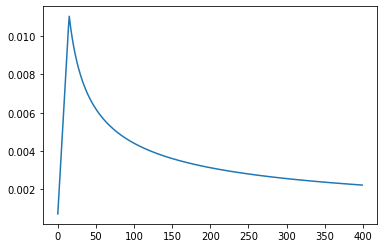

In [0]:
# Decaying lr from transformer paper
import matplotlib.pyplot as plt
lrate=[((512)**(-0.5))*min([(itr)**(-0.5),itr*4000**-0.5]) for itr in range(1,401)]
plt.plot(np.arange(400),lrate)

Enhancements:
*   Coverage Loss to be added - If attention is repeated at later time steps over the same token, a penalty is added. This is to avoid repetation in summary.
*   Experimentation with beam search and N gram blocking - checks for n grams between generated output and already generated summary. Excluded n grams which match from beam search.
*   Parallel processing using multiple GPUs
*   Experimentation with dropout
*   Masking to save padding indices multiplication
*   Experiment with decaying lr as mentioned in transformer paper







